In [50]:
import os
import numpy as np
import pandas as pd

# Sklearn
from sklearn.metrics import accuracy_score, recall_score, f1_score
import joblib

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# AIF360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

import seaborn as sns
import matplotlib.pyplot as plt

In [51]:

test_data = pd.read_csv('dataset/train_test_extracted_base/test.csv')

race_map = {0: "Other", 1: "AfricanAmerican", 2: "Asian", 3: "Caucasian", 4: "Hispanic"}
gender_map = {0: "Female", 1: "Male"}

test_data['race_str'] = test_data['race'].map(race_map)
test_data['gender_str'] = test_data['gender'].map(gender_map)
test_data['race_gender'] = test_data['race_str'] + "_" + test_data['gender_str']


drop_cols = ['readmitted','race','gender','race_str','gender_str','race_gender',
             'race_AfricanAmerican','race_Asian','race_Caucasian','race_Hispanic','race_Other']
X_test = test_data.drop(columns=drop_cols)
y_test = test_data['readmitted']

print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

model_paths = {
    'LogReg': 'models/base/LogReg.joblib',
    'XGB':    'models/base/XGB.joblib',
    'MLP':    'models/base/MLP.pth' 
}

X_test shape: (14924, 64) y_test shape: (14924,)


In [52]:

class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=2):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits



for model_name, path in model_paths.items():
    print(f"\n=== Loading {model_name} ===")

    if model_name in ['LogReg','XGB']:
        # scikit-learn model
        model = joblib.load(path)


        if model_name == 'LogReg':
            scaler_path = "models/base/scaler_LogReg.joblib"
            scaler = joblib.load(scaler_path)
            X_test_scaled = scaler.transform(X_test)
            y_pred = model.predict(X_test_scaled)
        elif model_name == 'XGB':
            y_pred = model.predict(X_test)

    else:

        input_dim = X_test.shape[1]
        mlp_model = SimpleNet(input_dim=input_dim, hidden_dim=64, num_classes=2)
        mlp_model.load_state_dict(torch.load(path))  # Load weights


        mlp_model.eval()
        X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
        with torch.no_grad():
            logits = mlp_model(X_test_t)
            probs = F.softmax(logits, dim=1)
            y_pred = torch.argmax(probs, dim=1).numpy()

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"[{model_name}] Accuracy: {acc:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    # Store predictions for bias analysis
    pred_col = f"pred_{model_name}"
    test_data[pred_col] = y_pred



=== Loading LogReg ===
[LogReg] Accuracy: 0.6506, Recall: 0.5137, F1: 0.2528

=== Loading XGB ===
[XGB] Accuracy: 0.6181, Recall: 0.6022, F1: 0.2662

=== Loading MLP ===
[MLP] Accuracy: 0.5340, Recall: 0.6861, F1: 0.2530


In [53]:
def build_aif360_subset(df, label_col, pred_col, unpriv_group_val, priv_group_val):
    """
    Filters 'df' so it only contains rows where race_gender is either unpriv_group_val or priv_group_val.
    Then encodes 'race_gender' as 1 => unpriv, 0 => priv.
    Returns two BinaryLabelDatasets (one ground truth, one predicted).
    Also prints debug info on how many times label=1 vs 0 in truth & predictions.
    """

    # Filter DataFrame
    df_filtered = df[df['race_gender'].isin([unpriv_group_val, priv_group_val])].copy()
    if df_filtered.empty:
        return None, None

    # Binarize race_gender => 1 if unpriv, else 0
    df_filtered['race_gender'] = df_filtered['race_gender'].apply(
        lambda x: 1 if x == unpriv_group_val else 0
    )

    unpriv_count = (df_filtered['race_gender'] == 1).sum()
    priv_count   = (df_filtered['race_gender'] == 0).sum()

    # Build dataset_true
    df_true = df_filtered[['race_gender', label_col]].copy()
    df_true.rename(columns={label_col: 'label'}, inplace=True)

    # Count how many label=1 vs. 0 in ground truth
    true_ones  = (df_true['label'] == 1).sum()
    true_zeros = (df_true['label'] == 0).sum()

    dataset_true = BinaryLabelDataset(
        favorable_label=0,
        unfavorable_label=1,
        df=df_true,
        label_names=['label'],
        protected_attribute_names=['race_gender']
    )

    # Build dataset_pred
    df_pred = df_filtered[['race_gender', pred_col]].copy()
    df_pred.rename(columns={pred_col: 'label'}, inplace=True)

    # Count how many label=1 vs. 0 in predictions
    pred_ones  = (df_pred['label'] == 1).sum()
    pred_zeros = (df_pred['label'] == 0).sum()

    dataset_pred = BinaryLabelDataset(
        favorable_label=0,
        unfavorable_label=1,
        df=df_pred,
        label_names=['label'],
        protected_attribute_names=['race_gender']
    )

    # Debug prints
    print(f"\n[DEBUG] build_aif360_subset => unpriv='{unpriv_group_val}'(=1), "
          f"priv='{priv_group_val}'(=0)")
    print(f"   => #rows in subset: {len(df_filtered)} (unpriv_count={unpriv_count}, priv_count={priv_count})")
    print(f"   => GroundTruth: label=1 => {true_ones}, label=0 => {true_zeros}")
    print(f"   => Predictions: label=1 => {pred_ones}, label=0 => {pred_zeros}")

    return dataset_true, dataset_pred


def compute_bias_metrics(dataset_true, dataset_pred):
    metric = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=[{'race_gender': 1}],
        privileged_groups=[{'race_gender': 0}]
    )
    spd = metric.statistical_parity_difference()
    di = metric.disparate_impact()
    eod = metric.equal_opportunity_difference()  
    aod = metric.average_odds_difference()       
    t_index = metric.theil_index()               
    return spd, di, eod, aod, t_index



def plot_fairness_bar(df, x_col, y_col, hue_col, title,
                      width=8, height=6, ref_line=None,
                      label_fontsize=8):

    plt.figure(figsize=(width, height))
    ax = sns.barplot(data=df, x=x_col, y=y_col, hue=hue_col)

    if ref_line is not None:
        plt.axhline(ref_line, color='black', linewidth=1)

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type='edge', 
                     padding=3, fontsize=label_fontsize)

    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


def build_aif360_subset_lumped(df, label_col, pred_col, privileged_grp="Asian_Female"):
    """
    Instead of splitting each unpriv group individually,
    we lump "everything that is not privileged_grp" into unpriv (1).
    """
    # Copy entire df (no filter for specific groups)
    df_temp = df.copy()

    # Binarize: 1 if not privileged_grp, else 0
    df_temp['race_gender'] = df_temp['race_gender'].apply(
        lambda x: 0 if x == privileged_grp else 1
    )

    # Build dataset_true
    df_true = df_temp[['race_gender', label_col]].copy()
    df_true.rename(columns={label_col: 'label'}, inplace=True)
    dataset_true = BinaryLabelDataset(
        favorable_label=0,
        unfavorable_label=1,
        df=df_true,
        label_names=['label'],
        protected_attribute_names=['race_gender']
    )

    # Build dataset_pred
    df_pred = df_temp[['race_gender', pred_col]].copy()
    df_pred.rename(columns={pred_col: 'label'}, inplace=True)
    dataset_pred = BinaryLabelDataset(
        favorable_label=0,
        unfavorable_label=1,
        df=df_pred,
        label_names=['label'],
        protected_attribute_names=['race_gender']
    )

    return dataset_true, dataset_pred




=== (A) Bias Analysis per Subgroup vs. 'Other_Female' ===

--- Model: pred_LogReg, Unprivileged: Other_Female ---

[DEBUG] build_aif360_subset => unpriv='Other_Female'(=1), priv='Caucasian_Female'(=0)
   => #rows in subset: 6077 (unpriv_count=136, priv_count=5941)
   => GroundTruth: label=1 => 700, label=0 => 5377
   => Predictions: label=1 => 2265, label=0 => 3812
   Compare Other_Female vs Caucasian_Female: SPD=0.0353, DI=1.0563

[DEBUG] build_aif360_subset => unpriv='Other_Female'(=1), priv='Caucasian_Male'(=0)
   => #rows in subset: 5527 (unpriv_count=136, priv_count=5391)
   => GroundTruth: label=1 => 637, label=0 => 4890
   => Predictions: label=1 => 1904, label=0 => 3623
   Compare Other_Female vs Caucasian_Male: SPD=0.0064, DI=1.0098

[DEBUG] build_aif360_subset => unpriv='Other_Female'(=1), priv='AfricanAmerican_Female'(=0)
   => #rows in subset: 1931 (unpriv_count=136, priv_count=1795)
   => GroundTruth: label=1 => 223, label=0 => 1708
   => Predictions: label=1 => 657, labe

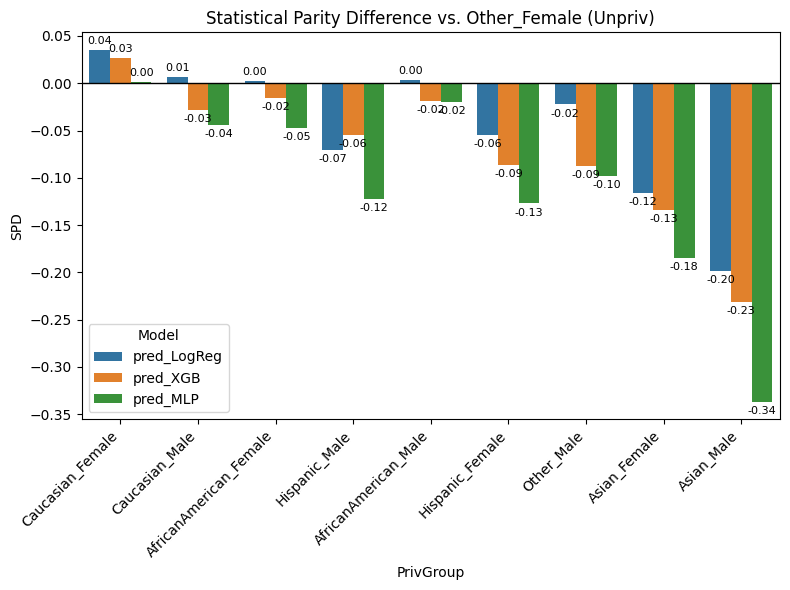

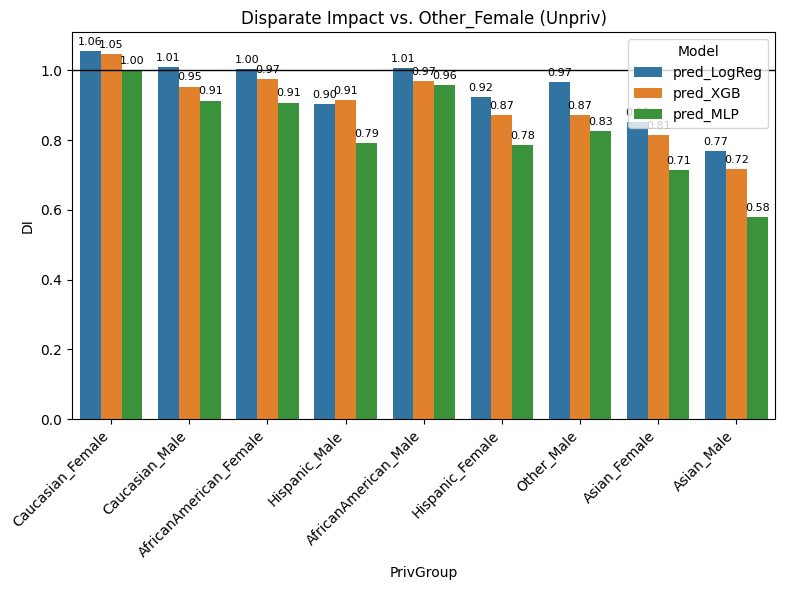


=== (B) Lumps => 'Other_Female' unpriv, All Others => priv ===
[pred_LogReg] 'Other_Female'(unpriv) vs ALL_OTHERS: SPD=0.0144, DI=1.0223
[pred_XGB] 'Other_Female'(unpriv) vs ALL_OTHERS: SPD=-0.0064, DI=0.9893
[pred_MLP] 'Other_Female'(unpriv) vs ALL_OTHERS: SPD=-0.0282, DI=0.9427

=== Aggregated Bias Results (Lumped) ===
          Model   UnprivGroup   PrivGroup       SPD        DI       EOD  \
0  pred_LogReg  Other_Female  ALL_OTHERS  0.014416  1.022269  0.035272   
1     pred_XGB  Other_Female  ALL_OTHERS -0.006368  0.989290  0.015607   
2     pred_MLP  Other_Female  ALL_OTHERS -0.028177  0.942662  0.002777   

        AOD   T_Index  
0 -0.031593  0.372832  
1 -0.052837  0.432469  
2 -0.101090  0.583130  

=== Plot SPD/DI => 'Other_Female'(unpriv) vs ALL_OTHERS ===


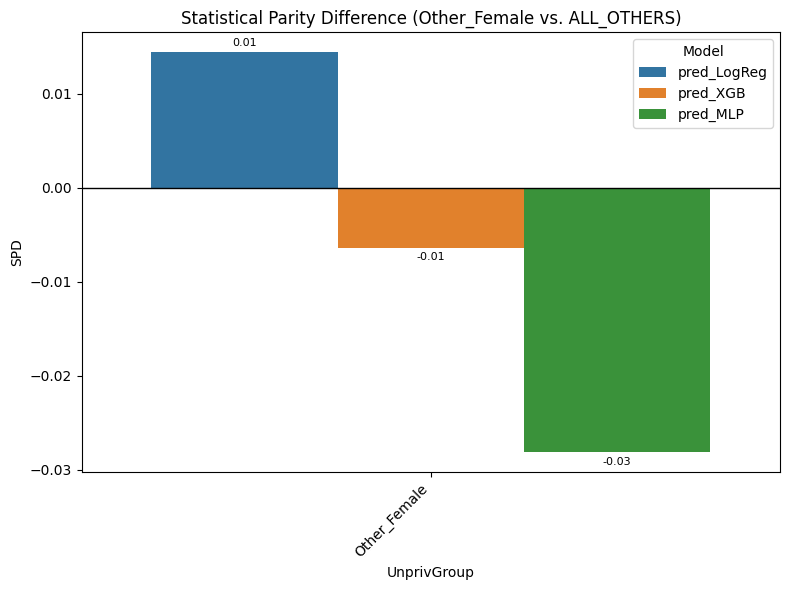

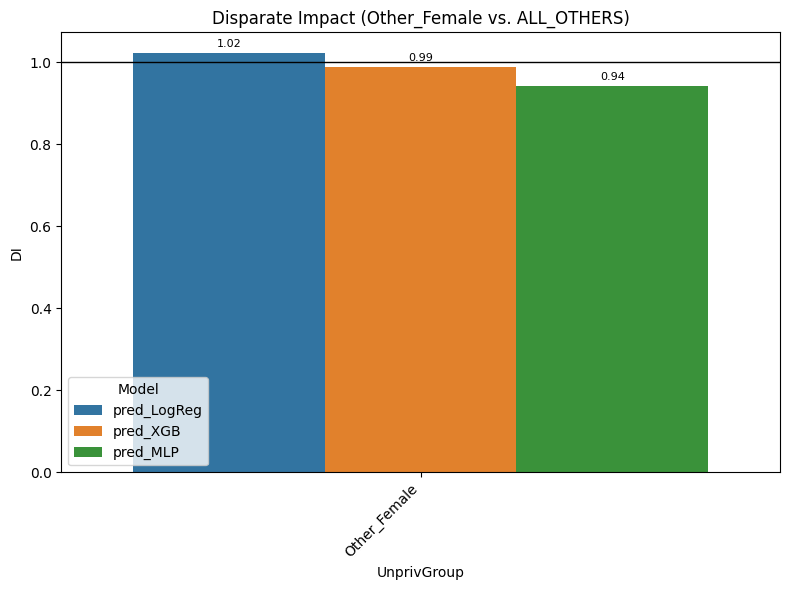

In [54]:

print("\n=== (A) Bias Analysis per Subgroup vs. 'Other_Female' ===")

UNPRIV_GROUP_OF = "Other_Female"
all_race_genders = test_data['race_gender'].unique()
privileged_groups = [g for g in all_race_genders if g != UNPRIV_GROUP_OF]

results_sep_OF = []
model_predictions = ['pred_LogReg','pred_XGB','pred_MLP']

for model_col in model_predictions:
    print(f"\n--- Model: {model_col}, Unprivileged: {UNPRIV_GROUP_OF} ---")
    for priv_grp in privileged_groups:
        ds_true, ds_pred = build_aif360_subset(
            df=test_data,
            label_col='readmitted',
            pred_col=model_col,
            unpriv_group_val=UNPRIV_GROUP_OF, 
            priv_group_val=priv_grp           
        )
        if ds_true is None or ds_pred is None:
            print(f"   WARNING: No data for group={priv_grp}; skipping.")
            continue

        spd, di, eod, aod, t_index = compute_bias_metrics(ds_true, ds_pred)
        print(f"   Compare {UNPRIV_GROUP_OF} vs {priv_grp}: SPD={spd:.4f}, DI={di:.4f}")

        results_sep_OF.append({
            'Model': model_col,
            'UnprivGroup': UNPRIV_GROUP_OF,
            'PrivGroup': priv_grp,
            'SPD': spd,
            'DI': di,
            'EOD': eod,
            'AOD': aod,
            'T_Index': t_index
        })

df_results_sep_OF = pd.DataFrame(results_sep_OF)
print("\n=== Aggregated Bias Results (Individual Groups) ===\n", df_results_sep_OF)

print("\n=== Plot SPD/DI for each Subgroup vs. Other_Female ===")
plot_fairness_bar(
    df=df_results_sep_OF,
    x_col='PrivGroup',
    y_col='SPD',
    hue_col='Model',
    title=f"Statistical Parity Difference vs. {UNPRIV_GROUP_OF} (Unpriv)",
    ref_line=0
)
plot_fairness_bar(
    df=df_results_sep_OF,
    x_col='PrivGroup',
    y_col='DI',
    hue_col='Model',
    title=f"Disparate Impact vs. {UNPRIV_GROUP_OF} (Unpriv)",
    ref_line=1
)


def build_aif360_subset_lumped_OF(df, label_col, pred_col):
    """
    Lump: 'Other_Female' => 1 (unpriv), everything else => 0 (priv).
    """
    df_temp = df.copy()
    df_temp['race_gender'] = df_temp['race_gender'].apply(
        lambda x: 1 if x == "Other_Female" else 0
    )
    # Build dataset_true
    df_true = df_temp[[ 'race_gender', label_col]].copy()
    df_true.rename(columns={label_col: 'label'}, inplace=True)
    dataset_true = BinaryLabelDataset(
        favorable_label=0,
        unfavorable_label=1,
        df=df_true,
        label_names=['label'],
        protected_attribute_names=['race_gender']
    )
    # Build dataset_pred
    df_pred = df_temp[['race_gender', pred_col]].copy()
    df_pred.rename(columns={pred_col: 'label'}, inplace=True)
    dataset_pred = BinaryLabelDataset(
        favorable_label=0,
        unfavorable_label=1,
        df=df_pred,
        label_names=['label'],
        protected_attribute_names=['race_gender']
    )
    return dataset_true, dataset_pred


print("\n=== (B) Lumps => 'Other_Female' unpriv, All Others => priv ===")
results_lumped_OF = []

for model_col in model_predictions:
    ds_true_lumped, ds_pred_lumped = build_aif360_subset_lumped_OF(
        df=test_data,
        label_col='readmitted',
        pred_col=model_col
    )
    spd, di, eod, aod, t_index = compute_bias_metrics(ds_true_lumped, ds_pred_lumped)
    print(f"[{model_col}] 'Other_Female'(unpriv) vs ALL_OTHERS: SPD={spd:.4f}, DI={di:.4f}")
    results_lumped_OF.append({
        'Model': model_col,
        'UnprivGroup': "Other_Female",
        'PrivGroup': "ALL_OTHERS",
        'SPD': spd,
        'DI': di,
        'EOD': eod,
        'AOD': aod,
        'T_Index': t_index
    })

df_results_lumped_OF = pd.DataFrame(results_lumped_OF)
print("\n=== Aggregated Bias Results (Lumped) ===\n", df_results_lumped_OF)

print("\n=== Plot SPD/DI => 'Other_Female'(unpriv) vs ALL_OTHERS ===")
plot_fairness_bar(
    df=df_results_lumped_OF,
    x_col='UnprivGroup',
    y_col='SPD',
    hue_col='Model',
    title="Statistical Parity Difference (Other_Female vs. ALL_OTHERS)",
    ref_line=0
)
plot_fairness_bar(
    df=df_results_lumped_OF,
    x_col='UnprivGroup',
    y_col='DI',
    hue_col='Model',
    title="Disparate Impact (Other_Female vs. ALL_OTHERS)",
    ref_line=1
)



=== (A) Bias Analysis: Subgroup vs. 'Asian_Female' (Privileged) ===

--- Model: pred_LogReg, Privileged: Asian_Female ---

[DEBUG] build_aif360_subset => unpriv='Caucasian_Female'(=1), priv='Asian_Female'(=0)
   => #rows in subset: 5995 (unpriv_count=5941, priv_count=54)
   => GroundTruth: label=1 => 688, label=0 => 5307
   => Predictions: label=1 => 2231, label=0 => 3764
   Compare unpriv=Caucasian_Female vs priv=Asian_Female: SPD=-0.1513, DI=0.8055

[DEBUG] build_aif360_subset => unpriv='Caucasian_Male'(=1), priv='Asian_Female'(=0)
   => #rows in subset: 5445 (unpriv_count=5391, priv_count=54)
   => GroundTruth: label=1 => 625, label=0 => 4820
   => Predictions: label=1 => 1870, label=0 => 3575
   Compare unpriv=Caucasian_Male vs priv=Asian_Female: SPD=-0.1224, DI=0.8426

[DEBUG] build_aif360_subset => unpriv='AfricanAmerican_Female'(=1), priv='Asian_Female'(=0)
   => #rows in subset: 1849 (unpriv_count=1795, priv_count=54)
   => GroundTruth: label=1 => 211, label=0 => 1638
   => Pr

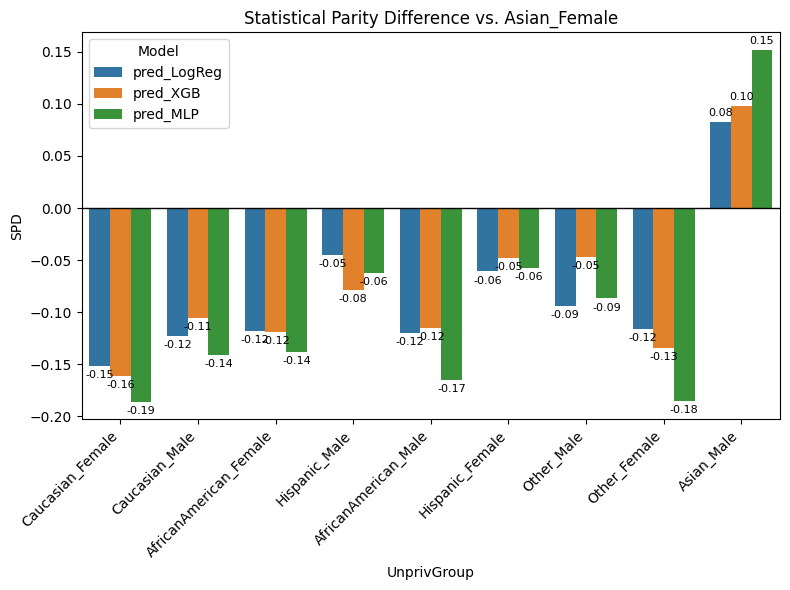

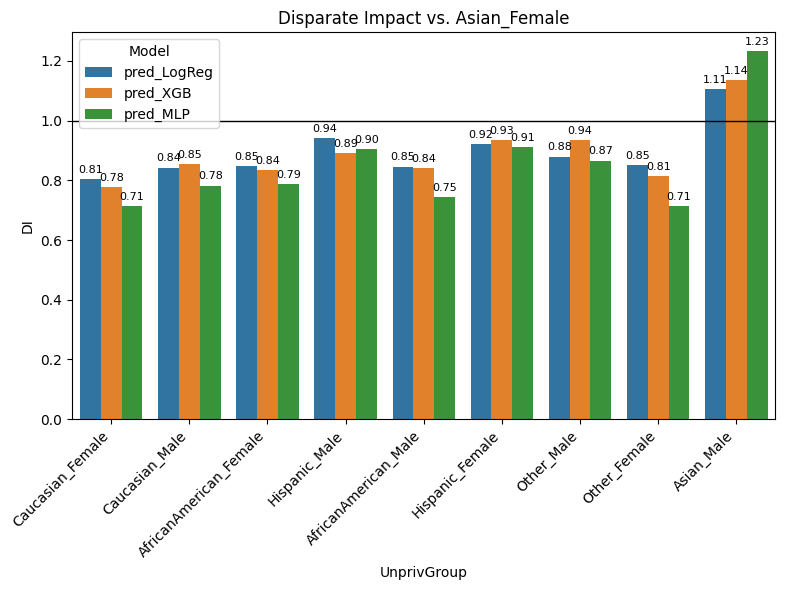


=== (B) Lumped Bias => 'Asian_Female' privileged vs. ALL_OTHERS unpriv ===
[pred_LogReg] Non-Asian_Female vs Asian_Female: SPD=-0.1308, DI=0.8319
[pred_XGB] Non-Asian_Female vs Asian_Female: SPD=-0.1281, DI=0.8226
[pred_MLP] Non-Asian_Female vs Asian_Female: SPD=-0.1576, DI=0.7569

=== Aggregated Bias Results (Lumped) ===
          Model UnprivGroup     PrivGroup       SPD        DI       EOD  \
0  pred_LogReg  ALL_OTHERS  Asian_Female -0.130770  0.831867 -0.102773   
1     pred_XGB  ALL_OTHERS  Asian_Female -0.128140  0.822575 -0.088529   
2     pred_MLP  ALL_OTHERS  Asian_Female -0.157563  0.756903 -0.132116   

        AOD   T_Index  
0 -0.225505  0.372832  
1 -0.262802  0.432469  
2 -0.243050  0.583130  

=== Plot SPD/DI => Non-Asian_Female vs 'Asian_Female' ===


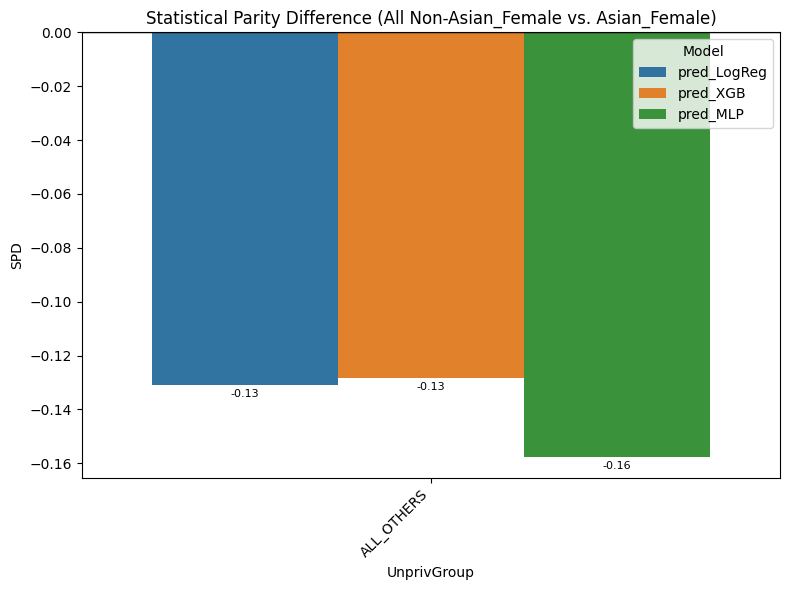

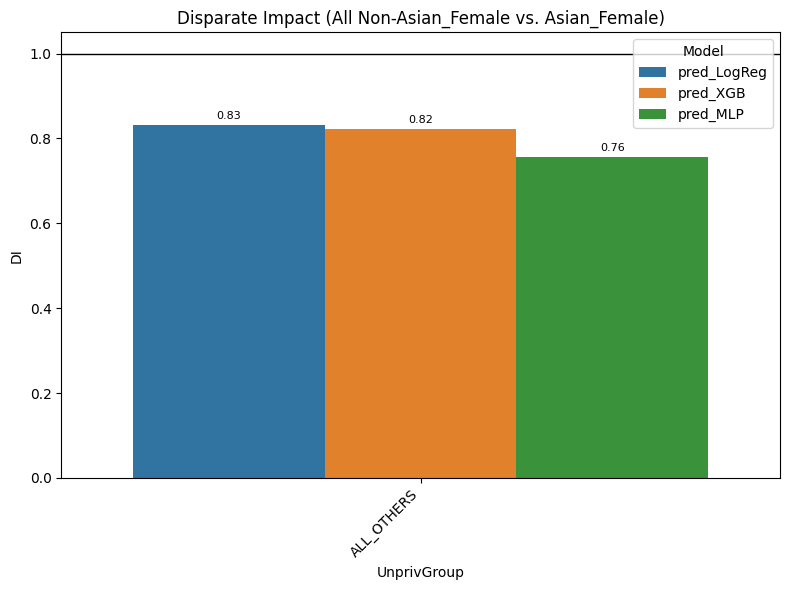

In [55]:
print("\n=== (A) Bias Analysis: Subgroup vs. 'Asian_Female' (Privileged) ===")

PRIV_GROUP_AF = "Asian_Female"
# all subgroups that are NOT 'Asian_Female' are tested as unprivileged, one by one
all_race_genders = test_data['race_gender'].unique()
unprivileged_groups = [g for g in all_race_genders if g != PRIV_GROUP_AF]

results_sep_AF = []
model_predictions = ['pred_LogReg','pred_XGB','pred_MLP']

for model_col in model_predictions:
    print(f"\n--- Model: {model_col}, Privileged: {PRIV_GROUP_AF} ---")
    for unpriv_grp in unprivileged_groups:
        ds_true, ds_pred = build_aif360_subset(
            df=test_data,
            label_col='readmitted',
            pred_col=model_col,
            unpriv_group_val=unpriv_grp,      # => 1
            priv_group_val=PRIV_GROUP_AF      # => 0
        )
        if ds_true is None or ds_pred is None:
            # If no rows match unpriv_grp or PRIV_GROUP_AF in test_data['race_gender']
            continue

        spd, di, eod, aod, t_index = compute_bias_metrics(ds_true, ds_pred)
        print(f"   Compare unpriv={unpriv_grp} vs priv={PRIV_GROUP_AF}: SPD={spd:.4f}, DI={di:.4f}")

        results_sep_AF.append({
            'Model': model_col,
            'UnprivGroup': unpriv_grp,
            'PrivGroup': PRIV_GROUP_AF,
            'SPD': spd,
            'DI': di,
            'EOD': eod,
            'AOD': aod,
            'T_Index': t_index
        })

df_results_sep_AF = pd.DataFrame(results_sep_AF)
print("\n=== Aggregated Bias Results (Individual Subgroups) ===\n", df_results_sep_AF)

# Plot SPD & DI
print("\n=== Plot SPD/DI for each Unpriv Subgroup vs. 'Asian_Female' ===")
plot_fairness_bar(
    df=df_results_sep_AF,
    x_col='UnprivGroup',
    y_col='SPD',
    hue_col='Model',
    title=f"Statistical Parity Difference vs. {PRIV_GROUP_AF}",
    ref_line=0
)
plot_fairness_bar(
    df=df_results_sep_AF,
    x_col='UnprivGroup',
    y_col='DI',
    hue_col='Model',
    title=f"Disparate Impact vs. {PRIV_GROUP_AF}",
    ref_line=1
)


print("\n=== (B) Lumped Bias => 'Asian_Female' privileged vs. ALL_OTHERS unpriv ===")

results_lumped_AF = []

for model_col in model_predictions:
    ds_true_lumped, ds_pred_lumped = build_aif360_subset_lumped(
        df=test_data,
        label_col='readmitted',
        pred_col=model_col,
        privileged_grp=PRIV_GROUP_AF
    )
    # This lumps everything that is not 'Asian_Female' => 1, 
    # 'Asian_Female' => 0

    spd, di, eod, aod, t_index = compute_bias_metrics(ds_true_lumped, ds_pred_lumped)
    print(f"[{model_col}] Non-Asian_Female vs {PRIV_GROUP_AF}: SPD={spd:.4f}, DI={di:.4f}")

    results_lumped_AF.append({
        'Model': model_col,
        'UnprivGroup': "ALL_OTHERS",
        'PrivGroup': PRIV_GROUP_AF,
        'SPD': spd,
        'DI': di,
        'EOD': eod,
        'AOD': aod,
        'T_Index': t_index
    })

df_results_lumped_AF = pd.DataFrame(results_lumped_AF)
print("\n=== Aggregated Bias Results (Lumped) ===\n", df_results_lumped_AF)

print("\n=== Plot SPD/DI => Non-Asian_Female vs 'Asian_Female' ===")
plot_fairness_bar(
    df=df_results_lumped_AF,
    x_col='UnprivGroup',
    y_col='SPD',
    hue_col='Model',
    title=f"Statistical Parity Difference (All Non-Asian_Female vs. {PRIV_GROUP_AF})",
    ref_line=0
)
plot_fairness_bar(
    df=df_results_lumped_AF,
    x_col='UnprivGroup',
    y_col='DI',
    hue_col='Model',
    title=f"Disparate Impact (All Non-Asian_Female vs. {PRIV_GROUP_AF})",
    ref_line=1
)


In [56]:
results_dir = "dataset/train_test_extracted_base"

df_results_sep_OF.to_csv(os.path.join(results_dir, "bias_results_sep_OF.csv"), index=False)
df_results_lumped_OF.to_csv(os.path.join(results_dir, "bias_results_lumped_OF.csv"), index=False)

df_results_sep_AF.to_csv(os.path.join(results_dir, "bias_results_sep_AF.csv"), index=False)
df_results_lumped_AF.to_csv(os.path.join(results_dir, "bias_results_lumped_AF.csv"), index=False)